# Numan SAHNOU
## Question Answering on the SQuAD Dataset

Stanford Question Answering Dataset (SQuAD) is a new reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage. With 100,000+ question-answer pairs on 500+ articles, SQuAD is significantly larger than previous reading comprehension datasets.

In [ ]:
import numpy as np
import pandas as pd 
import json

## Transform the JSON format into pandas dataframe

In [ ]:
def json_to_dataframe(file):

    f = open (file , "r") 
    data = json.loads(f.read())#Loading the json file.
    #Creating empty lists to store values.
    con = []
    Que = []
    Txt = []
    for i in range(len(data['data'])):       #Root tag of the json file contains 'title' tag & 'paragraphs' list.
        
        title = data['data'][i]['title']
        for p in range(len(data['data'][i]['paragraphs'])):  # 'paragraphs' list contains 'context' tag & 'qas' list.
            context = data['data'][i]['paragraphs'][p]['context']
                
            for q in range(len(data['data'][i]['paragraphs'][p]['qas'])):  # 'qas' list contains 'question', 'Id' tag & 'answers' list.
                
                question = data['data'][i]['paragraphs'][p]['qas'][q]['question']
                Id = data['data'][i]['paragraphs'][p]['qas'][q]['id']
                is_impossible = data['data'][i]['paragraphs'][p]['qas'][q]['is_impossible']
                for a in range(len(data['data'][i]['paragraphs'][p]['qas'][q]['answers'])): # 'answers' list contains 'ans_start', 'text' tags. 
                    
                    text = data['data'][i]['paragraphs'][p]['qas'][q]['answers'][a]['text']
                    
                    con.append(context)
                    Que.append(question)                
                    Txt.append(text)


    new_df = pd.DataFrame(columns=['Context','Question','Answer']) # Creating empty DataFrame.

    new_df.Context = con
    new_df.Question = Que
    new_df.Answer = Txt
    print('Done')
    final_df = new_df.drop_duplicates(keep='first')  # Dropping duplicate rows from the create Dataframe.
    return final_df

### Load the train and test datasets

In [ ]:
train = json_to_dataframe('train-v2.0.json')
test = json_to_dataframe('dev-v2.0.json')

Done
Done


### Visualize the data

In [ ]:
train

,Context,Question,Answer
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas"
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s
...,...,...,...
86816,"Kathmandu Metropolitan City (KMC), in order to...",In what US state did Kathmandu first establish...,Oregon
86817,"Kathmandu Metropolitan City (KMC), in order to...",What was Yangon previously known as?,Rangoon
86818,"Kathmandu Metropolitan City (KMC), in order to...",With what Belorussian city does Kathmandu have...,Minsk
86819,"Kathmandu Metropolitan City (KMC), in order to...",In what year did Kathmandu create its initial ...,1975


In [ ]:
test = test.reset_index(drop=True, inplace=False)
test

,Context,Question,Answer
0,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France
1,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries
2,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,in the 10th and 11th centuries
3,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway"
4,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo
...,...,...,...
10272,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,slug
10273,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,metric slug
10274,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,the metric slug
10275,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...,kip


### Get the start and end index words of the answers

In [ ]:
from keras.preprocessing.text import text_to_word_sequence

def get_start_end_words(row):
    answer = text_to_word_sequence(row['Answer'])
    context = text_to_word_sequence(row['Context'])
    
    start_word=end_word=-1
    
    match=False
    if not answer:
        row['Start_Word'] = start_word
        row['End_Word'] = end_word
        return row

    for j in range(len(context)-len(answer)):
        
        if context[j] == answer[0]:
            match=True
            k=0
            for k in range(1, len(answer)):
                if context[j+k] != answer[k]:
                    match=False
            if match==True:
                start_word=j
                end_word=j+k
                break
  
    row['Start_Word'] = start_word
    row['End_Word'] = end_word

    return row

In [ ]:
train =  train.apply(get_start_end_words, axis=1)
test =  test.apply(get_start_end_words, axis=1)

In [ ]:
train

,Context,Question,Answer,Start_Word,End_Word
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,42,45
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,31,33
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,88,88
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",25,26
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,44,45
...,...,...,...,...,...
86816,"Kathmandu Metropolitan City (KMC), in order to...",In what US state did Kathmandu first establish...,Oregon,30,30
86817,"Kathmandu Metropolitan City (KMC), in order to...",What was Yangon previously known as?,Rangoon,57,57
86818,"Kathmandu Metropolitan City (KMC), in order to...",With what Belorussian city does Kathmandu have...,Minsk,67,67
86819,"Kathmandu Metropolitan City (KMC), in order to...",In what year did Kathmandu create its initial ...,1975,24,24


### We remove the rows where we could not find the answers indexes

In [ ]:
train = train[train['Start_Word']!=-1]
test = test[test['Start_Word']!=-1]

In [ ]:
train = train.reset_index(drop=True, inplace=False)
test = test.reset_index(drop=True, inplace=False)

## We transform the Context and the Question to sequences

### Keras Tokenizer

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.Context)
tokenizer.fit_on_texts(train.Question)

tokenizer.fit_on_texts(test.Context)
tokenizer.fit_on_texts(test.Question)

### Vocab size

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

94929

### Transform the text into word sequences based on the vocabulary

In [ ]:
#train
context_sequences = tokenizer.texts_to_sequences(train.Context)
question_sequences = tokenizer.texts_to_sequences(train.Question)
#test
test_context_sequences = tokenizer.texts_to_sequences(test.Context)
test_question_sequences = tokenizer.texts_to_sequences(test.Question)

In [ ]:
#train
train["Context_Sequences"] = context_sequences
train["Question_Sequences"] = question_sequences
#test
test["Context_Sequences"] = test_context_sequences
test["Question_Sequences"] = test_question_sequences

### We pad the sequences in order to have the same lenght for each Context and each Question

In [ ]:
#train
context_padded = pad_sequences(context_sequences, maxlen = 700, padding="post")
question_padded = pad_sequences(question_sequences, maxlen = 50, padding="post")
#test
test_context_padded = pad_sequences(test_context_sequences, maxlen = 700, padding="post")
test_question_padded = pad_sequences(test_question_sequences, maxlen = 50, padding="post")

In [ ]:
#train
train["Context_Sequences"] = context_padded.tolist()
train["Question_Sequences"] = question_padded.tolist()
#test
test["Context_Sequences"] = test_context_padded.tolist()
test["Question_Sequences"] = test_question_padded.tolist()
train

,Context,Question,Answer,Start_Word,End_Word,Context_Sequences,Question_Sequences
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,42,45,"[653, 21187, 8601, 7659, 30926, 11471, 30927, ...","[46, 44, 5170, 765, 1087, 304, 0, 0, 0, 0, 0, ..."
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,31,33,"[653, 21187, 8601, 7659, 30926, 11471, 30927, ...","[17, 211, 44, 5170, 3504, 4, 46, 199, 9, 1076,..."
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,88,88,"[653, 21187, 8601, 7659, 30926, 11471, 30927, ...","[46, 44, 5170, 2145, 4990, 815, 3, 236, 6, 278..."
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",25,26,"[653, 21187, 8601, 7659, 30926, 11471, 30927, ...","[4, 17, 49, 3, 64, 44, 5170, 2153, 96, 0, 0, 0..."
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,44,45,"[653, 21187, 8601, 7659, 30926, 11471, 30927, ...","[4, 18, 1300, 44, 5170, 236, 810, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
82021,"Kathmandu Metropolitan City (KMC), in order to...",In what US state did Kathmandu first establish...,Oregon,30,30,"[2100, 967, 49, 38371, 4, 239, 5, 2668, 185, 1...","[4, 17, 217, 64, 44, 2100, 36, 1584, 23, 185, ..."
82022,"Kathmandu Metropolitan City (KMC), in order to...",What was Yangon previously known as?,Rangoon,57,57,"[2100, 967, 49, 38371, 4, 239, 5, 2668, 185, 1...","[17, 9, 17351, 920, 77, 8, 0, 0, 0, 0, 0, 0, 0..."
82023,"Kathmandu Metropolitan City (KMC), in order to...",With what Belorussian city does Kathmandu have...,Minsk,67,67,"[2100, 967, 49, 38371, 4, 239, 5, 2668, 185, 1...","[13, 17, 52700, 49, 130, 2100, 27, 6, 846, 0, ..."
82024,"Kathmandu Metropolitan City (KMC), in order to...",In what year did Kathmandu create its initial ...,1975,24,24,"[2100, 967, 49, 38371, 4, 239, 5, 2668, 185, 1...","[4, 17, 75, 44, 2100, 910, 32, 1725, 185, 846,..."


In [ ]:
max_length_context = len(train.Context_Sequences[0])
print(max_length_context)
max_length_question = len(train.Question_Sequences[0])
print(max_length_question)

700
50


### We define our features and labels for the train and test sets 

In [ ]:
X_train = train[['Context_Sequences','Question_Sequences']]
y_train = train[['Start_Word','End_Word']]

X_test = test[['Context_Sequences','Question_Sequences']]
y_test = test[['Start_Word','End_Word']]

In [ ]:
X_train

,Context_Sequences,Question_Sequences
0,"[653, 21187, 8601, 7659, 30926, 11471, 30927, ...","[46, 44, 5170, 765, 1087, 304, 0, 0, 0, 0, 0, ..."
1,"[653, 21187, 8601, 7659, 30926, 11471, 30927, ...","[17, 211, 44, 5170, 3504, 4, 46, 199, 9, 1076,..."
2,"[653, 21187, 8601, 7659, 30926, 11471, 30927, ...","[46, 44, 5170, 2145, 4990, 815, 3, 236, 6, 278..."
3,"[653, 21187, 8601, 7659, 30926, 11471, 30927, ...","[4, 17, 49, 3, 64, 44, 5170, 2153, 96, 0, 0, 0..."
4,"[653, 21187, 8601, 7659, 30926, 11471, 30927, ...","[4, 18, 1300, 44, 5170, 236, 810, 0, 0, 0, 0, ..."
...,...,...
82021,"[2100, 967, 49, 38371, 4, 239, 5, 2668, 185, 1...","[4, 17, 217, 64, 44, 2100, 36, 1584, 23, 185, ..."
82022,"[2100, 967, 49, 38371, 4, 239, 5, 2668, 185, 1...","[17, 9, 17351, 920, 77, 8, 0, 0, 0, 0, 0, 0, 0..."
82023,"[2100, 967, 49, 38371, 4, 239, 5, 2668, 185, 1...","[13, 17, 52700, 49, 130, 2100, 27, 6, 846, 0, ..."
82024,"[2100, 967, 49, 38371, 4, 239, 5, 2668, 185, 1...","[4, 17, 75, 44, 2100, 910, 32, 1725, 185, 846,..."


In [ ]:
y_train

0        42
1        31
2        88
3        25
4        44
         ..
82021    30
82022    57
82023    67
82024    24
82025     0
Name: Start_Word, Length: 82026, dtype: int64

## Load the GloVe word embedding
### GloVe is an unsupervised learning algorithm for obtaining vector representations for words (https://nlp.stanford.edu/projects/glove/)

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


### Now we create the embedding matrix. We match each word in the GloVe word embeddings vector and our words in the vocabulary

In [ ]:
count = 0
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
 embedding_vector = embeddings_index.get(word)
 if embedding_vector is not None:
    count += 1
    embedding_matrix[i] = embedding_vector

In [ ]:
print("Percentage of words covered by Glove vectors:", count/len(tokenizer.word_index)*100)

Percentage of words covered by Glove vectors: 71.92398449351087


# Defintion of the model (RNN Bi LSTM)

### Hyperparameters

In [354]:
vocab_size = len(tokenizer.word_index) + 1
embedding_vector_length = 100
max_span_begin = np.amax(y_train.Start_Word)
max_span_end = np.amax(y_train.End_Word)
batch = 32
# slice of data to be used as one epoch training on full data is expensive
slce = 10000

### Context input

In [355]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, MultiHeadAttention, concatenate, Flatten, Activation, dot

context_input = Input(shape=(max_length_context, ), dtype='int32', name='context_input')
x = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], 
              input_length=max_length_context, trainable=False)(context_input)

context_LSTM = Bidirectional(LSTM(200, return_sequences=True, dropout=0.2), merge_mode='concat')(x)

### Question input

In [356]:
question_input = Input(shape=(max_length_question, ), dtype='int32', name='ques_input')
x = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], 
              input_length=max_length_question, trainable=False)(question_input)

question_LSTM, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(200, return_sequences=True, return_state=True, dropout=0.2), merge_mode='concat')(x)

# /!\ We are not sure if add is the right approach or should be concat
question_hidden_states = concatenate([forward_h, backward_h])

### Attention layer
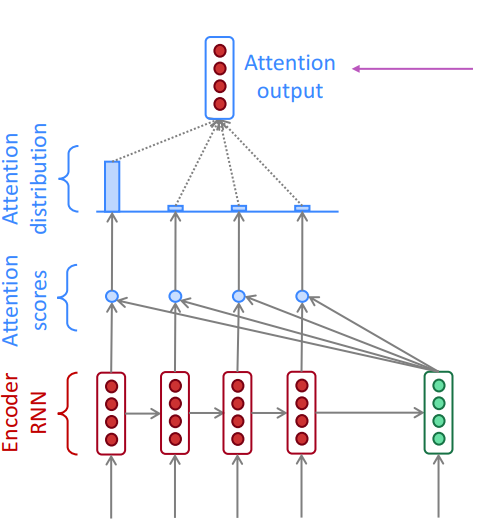

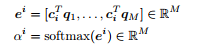

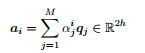

In [357]:
#ATTENTION LAYER 
import tensorflow as tf
attention_scores = dot([context_LSTM, question_LSTM], axes=2)
attention_distribution = tf.nn.softmax(attention_scores, axis=2)
#attention output is also the question vector
attention_output = dot([attention_distribution, question_LSTM],axes=[2,1])

question_to_context = concatenate([context_LSTM, attention_output])
#We used tanh activation because most of time tanh is quickly converge than sigmoid and performs better accuracy
attention_vector = Dense(400, use_bias=False, activation='tanh')(question_to_context)

### Output layer (Start and End word predictions)

In [359]:
#START WORD PREDICTION
start = Dense(400)(question_hidden_states)
#We use expand_dims from tensorflow to use the start vectors as a matrix to multiply the start vector with the attention vector
start_matrix = tf.expand_dims(start, 2)

#Squeeze removes dimensions of size 1 from the shape of a tensor we added before 
start_word = tf.squeeze(tf.matmul(attention_vector, start_matrix), 2)
start_word = tf.nn.softmax(start_word, axis=1,name = "Start_Word_Prediction")

#END WORD PREDICTION
end = Dense(400)(question_hidden_states)
end_matrix = tf.expand_dims(end, 2)

end_word = tf.squeeze(tf.matmul(attention_vector, end_matrix), 2)
end_word = tf.nn.softmax(end_word, axis=1,name = "End_Word_Prediction")

### We define the model and the metrics

In [360]:
#ATTEMPT FAIL
def compute_loss(start, end):
    J = tf.math.reduce_sum(tf.cast(start, tf.float64)) - tf.math.log(tf.cast(start, tf.float64)) + tf.math.reduce_sum(tf.cast(end, tf.float64)) - tf.math.log(tf.cast(end, tf.float64))
    return J

In [361]:
#DEFINE THE MODEL
model = Model(inputs=[context_input, question_input], outputs=[start_word, end_word])

model.compile(optimizer='Adam', loss="sparse_categorical_crossentropy", metrics=['acc'])
model.summary()

Model: "model_92"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      [(None, 700)]        0                                            
__________________________________________________________________________________________________
ques_input (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 700, 100)     9492900     context_input[0][0]              
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 50, 100)      9492900     ques_input[0][0]                 
___________________________________________________________________________________________

### Fitting of the model

In [362]:
model_history = model.fit([context_padded, question_padded], [y_train.Start_Word, y_train.End_Word], verbose=2, batch_size=batch, epochs=20)

Epoch 1/20
2564/2564 - 241s - loss: 6.3986 - tf.nn.softmax_29_loss: 3.3135 - tf.nn.softmax_30_loss: 3.0851 - tf.nn.softmax_29_acc: 0.1998 - tf.nn.softmax_30_acc: 0.2165
Epoch 2/20
2564/2564 - 236s - loss: 5.3245 - tf.nn.softmax_29_loss: 2.7753 - tf.nn.softmax_30_loss: 2.5492 - tf.nn.softmax_29_acc: 0.2919 - tf.nn.softmax_30_acc: 0.3112
Epoch 3/20
2564/2564 - 237s - loss: 4.8331 - tf.nn.softmax_29_loss: 2.5187 - tf.nn.softmax_30_loss: 2.3145 - tf.nn.softmax_29_acc: 0.3447 - tf.nn.softmax_30_acc: 0.3645
Epoch 4/20
2564/2564 - 237s - loss: 4.4192 - tf.nn.softmax_29_loss: 2.3066 - tf.nn.softmax_30_loss: 2.1127 - tf.nn.softmax_29_acc: 0.3862 - tf.nn.softmax_30_acc: 0.4071
Epoch 5/20
2564/2564 - 236s - loss: 4.1075 - tf.nn.softmax_29_loss: 2.1445 - tf.nn.softmax_30_loss: 1.9629 - tf.nn.softmax_29_acc: 0.4193 - tf.nn.softmax_30_acc: 0.4398
Epoch 6/20
2564/2564 - 236s - loss: 3.8292 - tf.nn.softmax_29_loss: 2.0017 - tf.nn.softmax_30_loss: 1.8275 - tf.nn.softmax_29_acc: 0.4519 - tf.nn.softmax_3

### Predictions

In [367]:
y_pred = model.predict([test_context_padded, test_question_padded])

y_pred_start= y_pred[0].argmax(axis=-1)
y_pred_end= y_pred[1].argmax(axis=-1)

y_pred_start = pd.DataFrame(y_pred_start, columns=["Start"])
y_pred_end = pd.DataFrame(y_pred_end, columns=["End"])
predictions = pd.DataFrame(y_pred_start)
predictions["End"] = y_pred_end

In [368]:
predictions

,Start,End
0,26,26
1,14,17
2,14,17
3,40,26
4,54,48
...,...,...
9717,114,2
9718,114,2
9719,114,2
9720,114,114


### Evaluation of the model on test set

In [369]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

d = {'Start_Word': [precision_score(y_test['Start_Word'], predictions['Start'], average="macro"), recall_score(y_test['Start_Word'], predictions['Start'], average="macro"), f1_score(y_test['Start_Word'], predictions['Start'], average="macro")],
                    'End_Word': [precision_score(y_test['End_Word'], predictions['End'], average="macro"), recall_score(y_test['End_Word'], predictions['End'], average="macro"), f1_score(y_test['End_Word'], predictions['End'], average="macro")]}
scores = pd.DataFrame(data=d)
scores.insert (0, "Raw", ['Precision', 'Recall', 'F1'])
scores.set_index('Raw')
scores

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Raw,Start_Word,End_Word
0,Precision,0.194466,0.205515
1,Recall,0.194340,0.218492
2,F1,0.183511,0.201898


# Evalutation of the model

In [372]:
def index_to_word(context_seq, context, question, answer, word_start, word_end):
    sentence = []
    sentence.append(context_seq[word_start:word_end+1])
    text = tokenizer.sequences_to_texts(sentence)
    print("Context : ", context, "\nQuestion:", question, "\nActual Answer:", answer, "\nPredicted Answer:", text[0], "\n\n\n")

for i in range(5,25):
    index_to_word(X_test.Context_Sequences[i], test.Context[i], test.Question[i], test['Answer'][i], predictions["Start"][i], predictions["End"][i])

Context :  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries. 
Question: What century did the Normans first gain their separate identity? 
Actual Answer: 10th century 
Predicted Answer: 10th and 11th centuries 



Context :  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=892561f3-bdc6-402b-bdd8-1c4a8ec9a749' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>